# Loading extensions/modules

In [2]:
# Extensions for code formatting and inline plotting
%load_ext nb_black
#%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
# Library importing
import pandas as pd
import numpy as np
import seaborn as sns
import math
import warnings
import os
import matplotlib.pyplot as plt
import logging
from prophet import Prophet

warnings.filterwarnings("ignore")
logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled=True

# Preferences
sns.set(rc={"figure.figsize": (15, 8.27)})
pd.set_option("display.float_format", "{:,}".format)
pd.set_option("display.max_columns", 30)
pd.set_option("display.max_rows", 30)

<IPython.core.display.Javascript object>

# Loading data

In [4]:
# Data retrieval function
def retrieve_data():
    os.chdir('..')
    cwd = os.getcwd()
    if 'data' in os.listdir():
        os.chdir(cwd + '\\data')
        df = pd.read_csv('data.csv', sep=';', decimal=',')
        df['ds'] = pd.to_datetime(df[['year','month']].assign(day=1))
        df['y'] = df['quantity'].round().astype('int64')
        df.drop(columns=['year','month','quantity'], inplace=True)
        return df

<IPython.core.display.Javascript object>

In [5]:
# data object
df = retrieve_data()

<IPython.core.display.Javascript object>

In [6]:
df.head(20)

,ds,y
0,2010-01-01,10205914
1,2010-02-01,10390060
2,2010-03-01,12392784
3,2010-04-01,10876033
4,2010-05-01,12035571
5,2010-06-01,10134094
6,2010-07-01,9561953
7,2010-08-01,9845679
8,2010-09-01,12236500
9,2010-10-01,10949143


<IPython.core.display.Javascript object>

# Plotting the data

[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'quantity'),
 Text(0.5, 1.0, 'Medicine sales over time')]

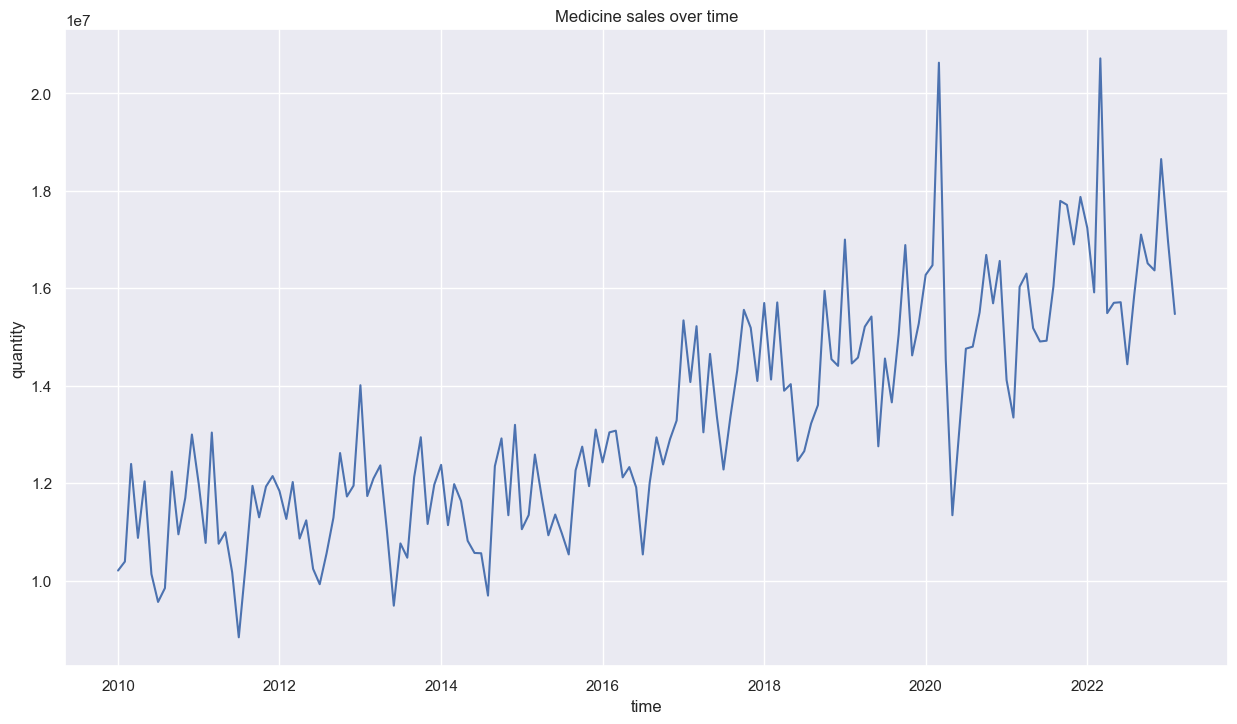

<IPython.core.display.Javascript object>

In [7]:
fig = sns.lineplot(df, x='ds', y='y')
fig.set(xlabel='time', ylabel='quantity', title='Medicine sales over time')

# Modelling with Facebook Prophet

## 1st model

In [8]:
# Initializing the prophet class model.
model = Prophet(
    seasonality_mode='multiplicative',
    yearly_seasonality=True,
    daily_seasonality=False,
    weekly_seasonality=False,
    interval_width=0.3,
    changepoint_range=0.7,
    changepoint_prior_scale=0.5,
)

# Fitting the data.
model.fit(df)

# Creating a future time series.
future = model.make_future_dataframe(periods=60, freq='MS', include_history=True)

# Making predictions.
forecast = model.predict(future)

<IPython.core.display.Javascript object>

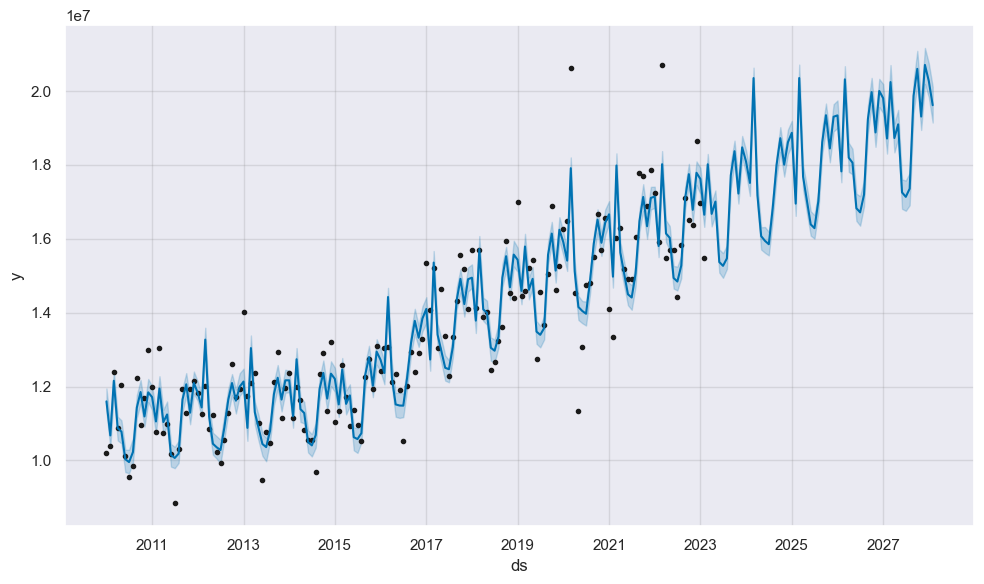

<IPython.core.display.Javascript object>

In [9]:
# Plotting facebook prophet predictions over entire time series.
a = model.plot(forecast)

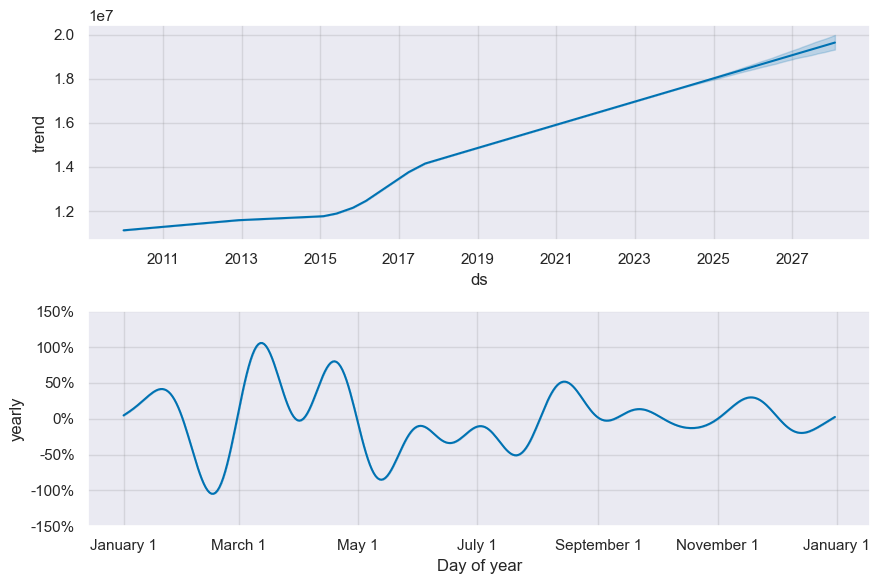

<IPython.core.display.Javascript object>

In [10]:
# Plotting trend and yeraly seasonality impact on data. 
plt = model.plot_components(forecast)

In [11]:
# Defining a fit_predict function with parameters for the given data to automatically fit and return the forecast with the model.
def fit_predict_model(
    dataframe, 
    interval_width = 0.8,
    changepoint_range = 0.8,
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10):
    m = Prophet(daily_seasonality = False, yearly_seasonality = True, weekly_seasonality = False,
               seasonality_mode = 'multiplicative',
               interval_width = interval_width,
               changepoint_range = changepoint_range,
               changepoint_prior_scale=changepoint_prior_scale,
               seasonality_prior_scale=seasonality_prior_scale)
    m = m.fit(dataframe)
    future = m.make_future_dataframe(periods=60, freq='MS', include_history=True) 
    forecast = m.predict(future)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    return forecast, m

<IPython.core.display.Javascript object>

In [12]:
# Example of the defined fit_predict
pred, model = fit_predict_model(df, 0.8, 0.99)

<IPython.core.display.Javascript object>

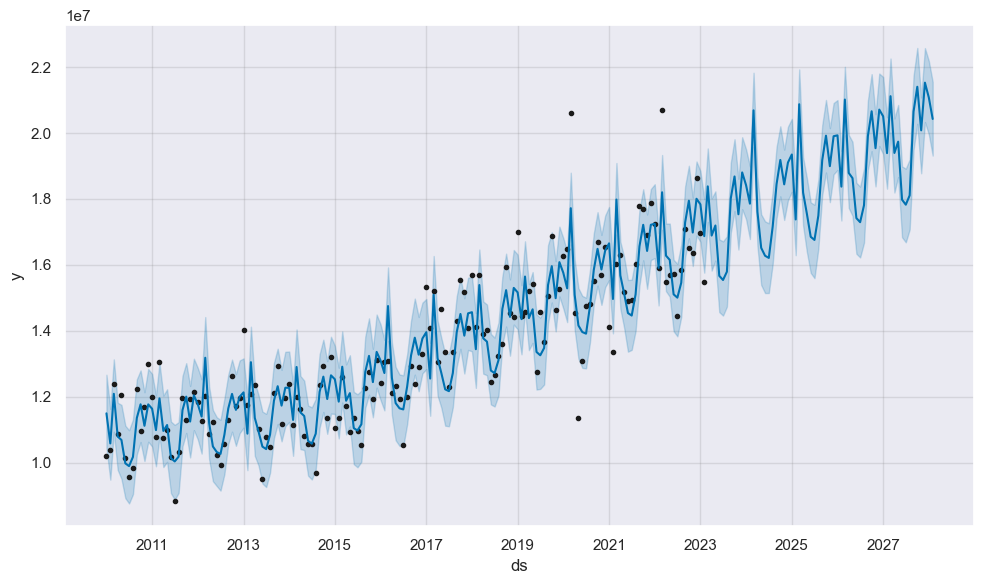

<IPython.core.display.Javascript object>

In [13]:
#plotting the fit_predict
f = model.plot(pred)

### Using cross validation

In [14]:
# Using cross validation to estimate the model
from prophet.diagnostics import cross_validation

# creating the cross validation dataframe.
df_cv = cross_validation(
    model, 
    initial='731 days', 
    horizon='365 days',
    period='365 days',
    parallel = 'processes'
)

<IPython.core.display.Javascript object>

In [15]:
# Inspecting the result
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-03-01,"12,007,813.392546922","11,852,410.264958162","12,182,818.896720184",12021802,2012-02-04
1,2012-04-01,"11,145,809.684350755","10,961,998.965428181","11,317,723.297368132",10862213,2012-02-04
2,2012-05-01,"13,662,250.72295567","13,492,500.271241143","13,831,949.923975185",11235651,2012-02-04
3,2012-06-01,"9,167,891.67900805","8,982,194.998484038","9,365,074.350929767",10240797,2012-02-04
4,2012-07-01,"10,404,353.079729186","10,213,478.18376239","10,607,393.471524887",9925310,2012-02-04


<IPython.core.display.Javascript object>

In [16]:
# Extracting the performance metrics using prophet.diagnostics and inspecting them.
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv, monthly=True)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,2,"791,969,765,861.6235","889,926.8317460844","616,534.218422748",0.04209745083517573,0.041453980754498125,0.042272811553587246,0.7482517482517482
1,3,"2,537,443,751,059.421","1,592,935.57655651","1,105,973.1573194882",0.09101957718380162,0.04538706914001264,0.08450273673824944,0.5874125874125874
2,4,"1,461,883,232,861.943","1,209,083.6335266237","1,041,428.3011069249",0.08629849989236935,0.09018934948086463,0.08552597550545123,0.3146853146853147
3,5,"680,448,356,003.0449","824,892.9360850685","753,091.2209032486",0.061166056222110625,0.05053876748042722,0.06243340132263534,0.42657342657342656
4,6,"857,257,209,999.4673","925,881.8553138771","720,054.0230166537",0.05984231903722378,0.04826479774729317,0.06221257390146305,0.5314685314685315


<IPython.core.display.Javascript object>

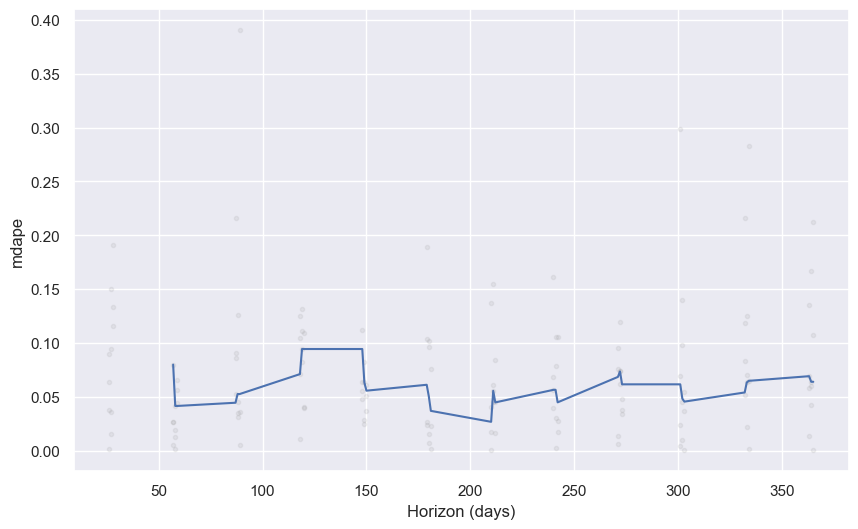

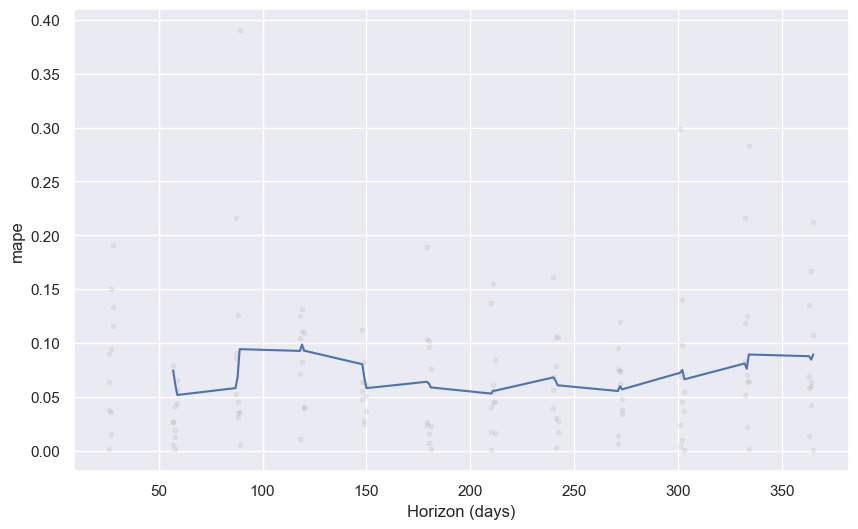

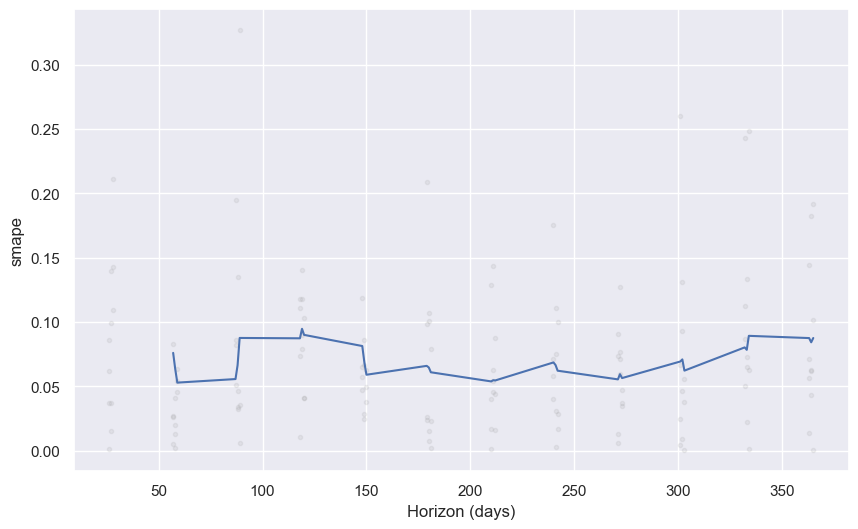

<IPython.core.display.Javascript object>

In [17]:
# Plotting the rmse and mape metrics
from prophet.plot import plot_cross_validation_metric
a = plot_cross_validation_metric(df_cv, metric='mdape')
b = plot_cross_validation_metric(df_cv, metric='mape')
c = plot_cross_validation_metric(df_cv, metric='smape')

In [18]:
# Mean absolute percentage error
df_p['mape'].mean()

0.07024938290610552

<IPython.core.display.Javascript object>

In [19]:
# Function to evaluate the model using performance metrics.

def evaluate_model(model):
    df_cv = cross_validation(
    model, 
    initial='731 days', 
    horizon='365 days',
    period='365 days',
    parallel = 'processes')
    df_p = performance_metrics(df_cv, monthly=True)
    mdape = df_p['mdape'].mean()
    mape = df_p['mape'].mean()
    smape = df_p['smape'].mean()
    print(f'MAPE: {mape:.3%}\nMDAPE: {mdape:.3%}\nSMAPE: {smape:.3%}')

<IPython.core.display.Javascript object>

In [20]:
# Evaluating the model
evaluate_model(model)

MAPE: 7.025%
MDAPE: 5.671%
SMAPE: 6.952%


<IPython.core.display.Javascript object>

### Removing shock and anomalies from the data 

In [21]:
# Function to detect anomalies in the time series using confidence intervals of yhat_lower and yhat_upper.

def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1
#anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']

    return forecasted

<IPython.core.display.Javascript object>

In [22]:
# Example of detecting anomalies in the dataset. Importance defines the distance from the actual data point hence, the higher the value the more importance.
pred = detect_anomalies(pred)
pred[pred['anomaly'] != 0].sort_values(by='importance')[:5]

,ds,trend,yhat,yhat_lower,yhat_upper,fact,anomaly,importance
14,2011-03-01,"11,240,046.58492544","11,948,324.852574289","10,793,859.337987449","13,026,134.017219512","13,036,873.0",1,0.0008237391574258803
96,2018-01-01,"13,970,335.57679655","14,563,353.969495337","13,374,570.867341338","15,633,568.178394789","15,694,288.0",1,0.0038689121548687727
18,2011-07-01,"11,302,158.528980078","10,032,235.412905898","8,870,438.121423993","11,141,987.198305901","8,836,242.0",-1,0.0038699847088833985
121,2020-02-01,"15,311,812.580238765","15,287,295.095202548","14,260,737.54467672","16,404,248.922204029","16,470,034.0",1,0.003994228414827267
110,2019-03-01,"14,717,760.726451831","15,645,183.04559066","14,642,023.437036507","16,715,066.141371489","14,575,332.0",-1,0.0045756375934700375


<IPython.core.display.Javascript object>

In [23]:
# Function to remove anomalies from a dataframe.
def remove_anomalies(df, predictions):
    anomaly_list = predictions[predictions['anomaly'] != 0]['ds']
    return df[~df['ds'].isin(anomaly_list)]

<IPython.core.display.Javascript object>

In [24]:
# Removing anomalies from the original df.
dfc = remove_anomalies(df, pred)

<IPython.core.display.Javascript object>

In [25]:
dfc

,ds,y
1,2010-02-01,10390060
2,2010-03-01,12392784
3,2010-04-01,10876033
5,2010-06-01,10134094
6,2010-07-01,9561953
...,...,...
151,2022-08-01,15846756
152,2022-09-01,17098276
154,2022-11-01,16363748
155,2022-12-01,18647412


<IPython.core.display.Javascript object>

## Feature engineering parameters

In [26]:
# Param map generated by hyper_tuner that evalutes rmse
{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'changepoint_range': 0.8}

{'changepoint_prior_scale': 0.001,
 'seasonality_prior_scale': 0.01,
 'changepoint_range': 0.8}

<IPython.core.display.Javascript object>

## Model 2

In [27]:
# Using the new dataframe with removed anomalies and best features.
pred2, model2 = fit_predict_model(
    dfc, 
    changepoint_prior_scale=0.1,
    seasonality_prior_scale=0.01,
    changepoint_range=0.95)

<IPython.core.display.Javascript object>

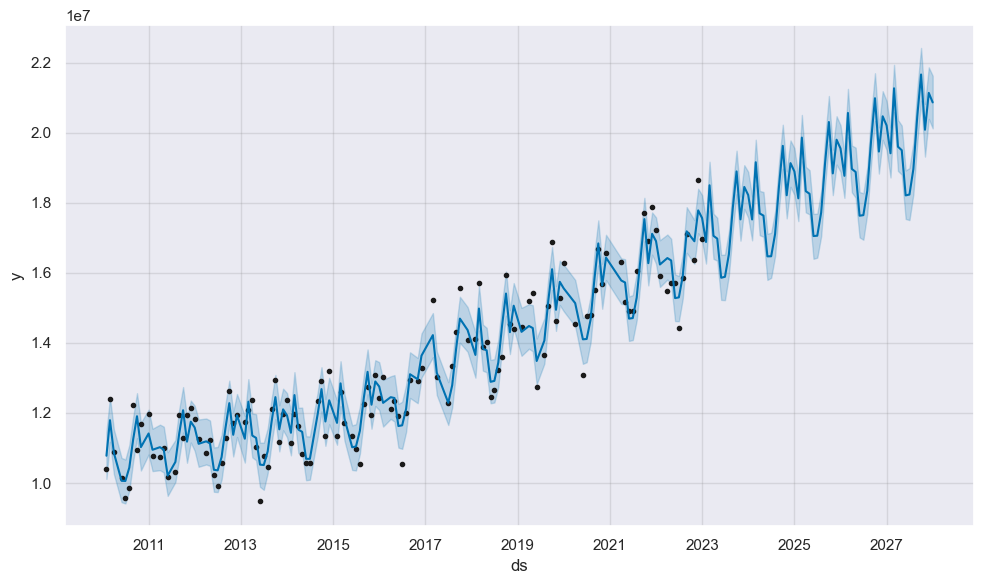

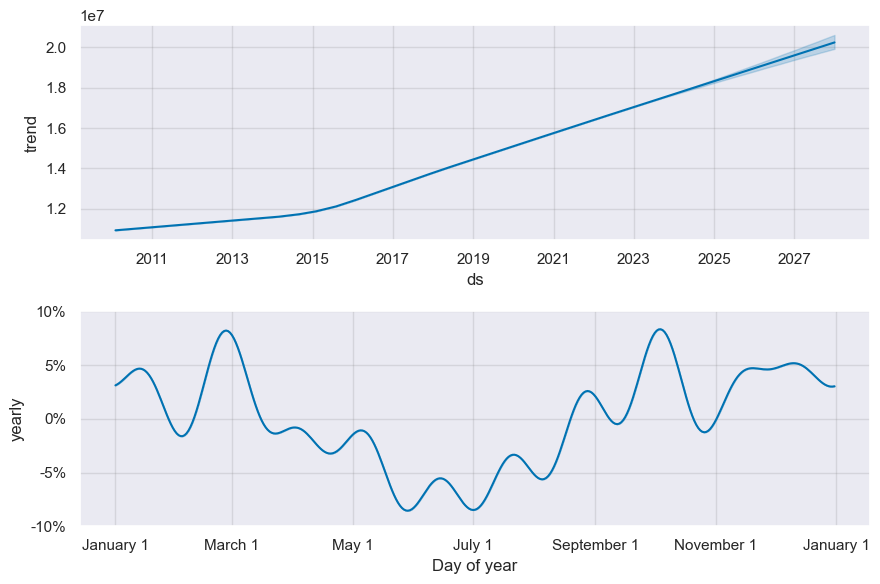

<IPython.core.display.Javascript object>

In [28]:
a = model2.plot(pred2)
b = model2.plot_components(pred2)

In [29]:
# Evaluating the model
evaluate_model(model2)

MAPE: 4.271%
MDAPE: 3.950%
SMAPE: 4.272%


<IPython.core.display.Javascript object>

We can see that the model is performing better and that yearly seasonality has less impact on the predictions.

## Model 3

In [30]:
# Detecting anomalies from the previous model predictions
anomalies2 = detect_anomalies(pred2)

<IPython.core.display.Javascript object>

In [31]:
anomalies2

,ds,trend,yhat,yhat_lower,yhat_upper,fact,anomaly,importance
0,2010-02-01,"10,923,486.122892","10,780,055.495097348","10,118,766.05150429","11,466,662.60156569","10,390,060.0",0,0.0
1,2010-03-01,"10,936,208.678485123","11,794,166.662773302","11,177,775.314080015","12,439,275.03200454","12,392,784.0",0,0.0
2,2010-04-01,"10,950,294.365034653","10,860,442.02998595","10,255,136.305127682","11,528,841.368650295","10,876,033.0",0,0.0
3,2010-06-01,"10,978,011.361148246","10,065,100.561399478","9,454,156.371795904","10,717,022.342402166","10,134,094.0",0,0.0
4,2010-07-01,"10,991,642.670712309","10,059,326.026216818","9,417,309.676294409","10,672,771.896187939","9,561,953.0",0,0.0
...,...,...,...,...,...,...,...,...
182,2027-09-01,"20,032,809.735586397","20,470,560.152589165","19,715,546.518534333","21,242,659.594820913",NaN,0,0.0
183,2027-10-01,"20,085,481.69971361","21,661,979.66588516","20,918,495.49699967","22,420,038.51477512",NaN,0,0.0
184,2027-11-01,"20,139,909.39597839","20,084,756.140209403","19,318,801.928861555","20,823,611.568887606",NaN,0,0.0
185,2027-12-01,"20,192,581.360105596","21,137,498.139676504","20,396,334.700409483","21,865,894.154145647",NaN,0,0.0


<IPython.core.display.Javascript object>

In [32]:
# Cleaning the dataset further
dfc2 = remove_anomalies(dfc,anomalies2)

<IPython.core.display.Javascript object>

In [33]:
# Fitting the data onto the model
pred3, model3 = fit_predict_model(
    dfc2, 
    changepoint_prior_scale=0.1,
    seasonality_prior_scale=0.01,
    changepoint_range=0.95)

<IPython.core.display.Javascript object>

In [34]:
evaluate_model(model3)

MAPE: 2.971%
MDAPE: 2.882%
SMAPE: 2.981%


<IPython.core.display.Javascript object>

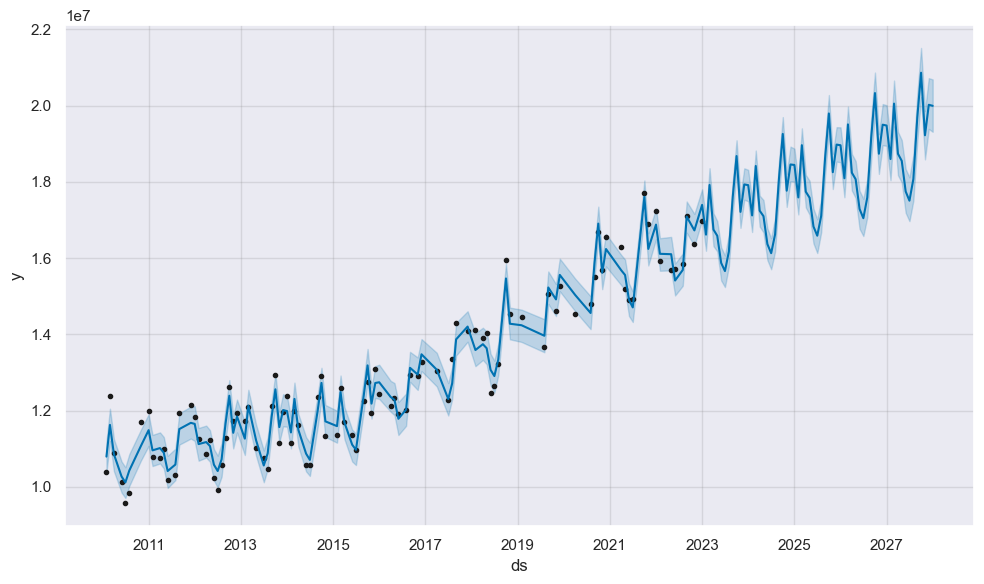

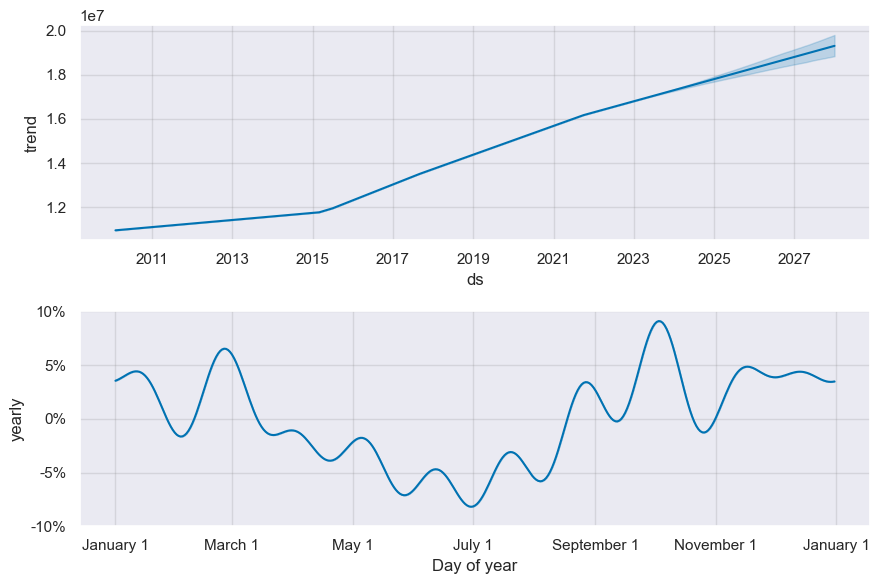

<IPython.core.display.Javascript object>

In [35]:
a = model3.plot(pred3)
b = model3.plot_components(pred3)